# Phân tích bộ dữ liệu `Heart Disease`


## 1. Preparing datasets

In [ ]:
# %pip install numpy matplotlib seaborn graphviz

# --- Thư viện cơ bản ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import os

# --- Thư viện cho Machine Learning ---
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- Định nghĩa các đường dẫn ---
# Đi từ `notebooks` ra ngoài một cấp để thấy các thư mục khác
DATA_PATH = '../data/heart_disease.csv'
OUTPUT_DIR = '../outputs/heart_disease/'
# Tạo thư mục output nếu nó chưa tồn tại
os.makedirs(OUTPUT_DIR, exist_ok=True)

# (Tùy chọn) Thêm thư mục src vào path để import các hàm từ utils.py
import sys
sys.path.append('../')
from src.utils import plot_label_distribution, plot_label_original, build_decision_tree # Ví dụ nếu bạn có hàm riêng

from sklearn.impute import SimpleImputer

# --- Tải và khám phá dữ liệu ---
df = pd.read_csv(DATA_PATH)

# Chuyển cột 'num' thành nhãn nhị phân (0: không bệnh, 1: có bệnh)
df['num'] = (df['num'] > 0).astype(int)

# 1. Tách features và labels
features = df.drop('num', axis=1)
labels = df['num']

# 2. Áp dụng One-Hot Encoding
print("Áp dụng One-Hot Encoding...")
features_encoded = pd.get_dummies(features)
print(f"Số lượng features sau One-Hot Encoding: {features_encoded.shape[1]}")

# 3. Xử lý giá trị thiếu (NaN)
print("\nXử lý các giá trị bị thiếu...")
imputer = SimpleImputer(strategy='median')
# Dùng features_final để lưu lại kết quả cuối cùng
features_final = pd.DataFrame(imputer.fit_transform(features_encoded), columns=features_encoded.columns)

# 4. Chia dữ liệu train/test (SỬ DỤNG features_final)
print("\nChia dữ liệu thành tập train và test...")

# Phân chia train và test theo tỷ lệ
feature_train_60, feature_test_40, label_train_60, label_test_40 = train_test_split(
        features_final, labels, test_size=0.4, shuffle=True, stratify=labels, random_state=42)

feature_train_40, feature_test_60, label_train_40, label_test_60 = train_test_split(
        features_final, labels, test_size=0.6, shuffle=True, stratify=labels, random_state=42)

feature_train_80, feature_test_20, label_train_80, label_test_20 = train_test_split(
        features_final, labels, test_size=0.2, shuffle=True, stratify=labels, random_state=42)

feature_train_90, feature_test_10, label_train_90, label_test_10 = train_test_split(
        features_final, labels, test_size=0.1, shuffle=True, stratify=labels, random_state=42)

#Tạo biểu đồ ban đầu
print("Đang tạo biểu đồ gốc...")
plot_label_original(labels, OUTPUT_DIR)

print("Đang tạo các biểu đồ phân phối lớp...")
# Tạo các biểu đồ được phân chia
plot_label_distribution(label_train_60, label_test_40, 60, 40, OUTPUT_DIR)
plot_label_distribution(label_train_40, label_test_60, 40, 60, OUTPUT_DIR)
plot_label_distribution(label_train_80, label_test_20, 80, 20, OUTPUT_DIR)
plot_label_distribution(label_train_90, label_test_10, 90, 10, OUTPUT_DIR)

print("Hoàn tất xử lý dữ liệu!")

Áp dụng One-Hot Encoding...
Số lượng features sau One-Hot Encoding: 30

Xử lý các giá trị bị thiếu...

Thông tin dữ liệu sau khi xử lý hoàn tất:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        920 non-null    float64
 1   age                       920 non-null    float64
 2   trestbps                  920 non-null    float64
 3   chol                      920 non-null    float64
 4   thalch                    920 non-null    float64
 5   oldpeak                   920 non-null    float64
 6   ca                        920 non-null    float64
 7   sex_Female                920 non-null    float64
 8   sex_Male                  920 non-null    float64
 9   dataset_Cleveland         920 non-null    float64
 10  dataset_Hungary           920 non-null    float64
 11  dataset_Switzerland       920 

## 2. Building the decision tree classifiers


In [ ]:
print("Đang tạo confusion matrix 60/40...")
build_decision_tree(features_final, feature_train_60, feature_test_40, label_train_60, label_test_40, 60, 40, OUTPUT_DIR)

print("Đang tạo confusion matrix 40/60...")
build_decision_tree(features_final, feature_train_40, feature_test_60, label_train_40, label_test_60, 40, 60, OUTPUT_DIR)

print("Đang tạo confusion matrix 80/20...")
build_decision_tree(features_final, feature_train_80, feature_test_20, label_train_80, label_test_20, 80, 20, OUTPUT_DIR)

print("Đang tạo confusion matrix 90/10...")
build_decision_tree(features_final, feature_train_90, feature_test_10, label_train_90, label_test_10, 90, 10, OUTPUT_DIR)

Confusion matrix đã được lưu tại: ../outputs/heart_disease/matrices/confusion_matrix_60_40.png
Confusion matrix đã được lưu tại: ../outputs/heart_disease/matrices/confusion_matrix_40_60.png
Confusion matrix đã được lưu tại: ../outputs/heart_disease/matrices/confusion_matrix_80_20.png
Confusion matrix đã được lưu tại: ../outputs/heart_disease/matrices/confusion_matrix_90_10.png


## 3. Evaluating the decision tree classifiers


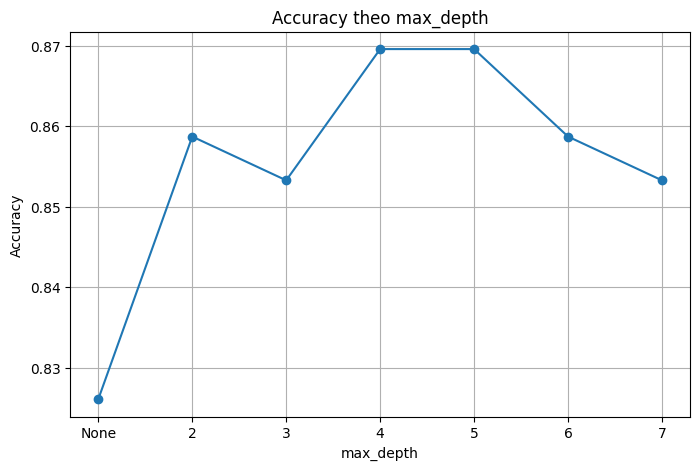

In [ ]:
# Độ sâu
depths = [None, 2, 3, 4, 5, 6, 7]
accuracies = []

output_dir = '../outputs/heart_disease/acc/'
os.makedirs(output_dir, exist_ok=True)
results = []

for depth in depths:
    str_depth = f" với độ sâu là {depth} " if depth is not None else ""
    print(f"Đang tạo và đánh giá cây quyết định{str_depth}...")
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=42)
    clf.fit(feature_train_80, label_train_80)

    # Vẽ và lưu cây
    dot_data = export_graphviz(clf, out_file=None, feature_names=features_final.columns, class_names=["0", "1"],
                               filled=True, rounded=True, special_characters=True)
    graph = graphviz.Source(dot_data)
    filename = f"{output_dir}tree_depth_{depth if depth else 'None'}"
    graph.render(filename=filename, format="pdf", cleanup=True)
    print(f"Cây đã được lưu tại {filename}")


## 4. The depth and accuracy of a decision tree


In [ ]:
print("Đang tạo bảng accuracy_score...")
for depth in depths:
    y_pred = clf.predict(feature_test_20)
    acc = accuracy_score(label_test_20, y_pred)
    accuracies.append(acc)

    results.append({
        "max_depth": str(depth),
        "Accuracy": acc
    })

# Chuyển sang dict với key là max_depth, value là accuracy
accuracy_dict = {entry["max_depth"]: entry["Accuracy"] for entry in results}

# Tạo DataFrame dạng 1 dòng, với index là Accuracy
results_df = pd.DataFrame([accuracy_dict], index=["Accuracy"])
results_df.columns.name = "max_depth"  # Gán tên cột

# Lưu vào CSV
results_df.to_csv(f"{output_dir}accuracy_score.csv", index=True, index_label="max_depth")
print(f"Đã tạo bảng accuracy_score tại {output_dir}accuracy_score.csv")

plt.figure(figsize=(8, 5))
plt.plot([str(d) for d in depths], accuracies, marker='o')
plt.title("Chart")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.grid(True)
plt.savefig(f"{output_dir}accuracy_vs_depth.png")
plt.close()
print(f"Đã tạo biểu đồ accuracy_score tại {output_dir}accuracy_vs_depth.png")
